In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
# make this notebook work better with Scanpy
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

In [2]:
# make output directories
import os
if not os.path.exists("scRNA_out"):
    os.mkdir("scRNA_out")

if not os.path.exists("scRNA_out/infercnv/"):
    os.mkdir("scRNA_out/infercnv/")

In [3]:
sc.set_figure_params(transparent=True, dpi_save=400)
sc.settings.figdir = "scRNA_out/infercnv/"

In [4]:
from pyensembl import EnsemblRelease

# release 98 uses human reference genome GRCh38
data = EnsemblRelease(98)

---
# Read in data

In [5]:
vumc_dis_epi = sc.read("../data/scRNA/VUMC_HTAN_DIS_EPI_V2.h5ad"); vumc_dis_epi

AnnData object with n_obs × n_vars = 65088 × 35272
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Polyp_Type', 'Sample_Classification', 'Patient', 'Tumor_Type'

In [6]:
broad_epi = sc.read("../data/scRNA/Broad_Epi_CRC_NoNormal_ReFiltered_Counts.h5ad"); broad_epi

AnnData object with n_obs × n_vars = 60665 × 20154
    obs: 'Cell_Type', 'MMRMLH1Tumor', 'MMRStatusTumor', 'PatientBarcode', 'Polyp_Type', 'Sample_Classification'
    var: 'n_cells'

In [7]:
vumc_crc_epi = sc.read("../data/scRNA/abnormal_epithelium.h5ad")
vumc_crc_epi = vumc_crc_epi[vumc_crc_epi.obs["Tumor_Type"].isin(["MSI","MSS"]),:].copy()
del vumc_crc_epi.uns
del vumc_crc_epi.var
del vumc_crc_epi.obsm
vumc_crc_epi.obs.drop(columns=["cnv_leiden","CNV Score","CNV Clone"], inplace=True)
vumc_crc_epi.obs["Polyp_Type"] = "CRC"
vumc_crc_epi.obs["Sample_Classification"] = "CRC"
vumc_crc_epi

AnnData object with n_obs × n_vars = 2706 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient', 'Cytotoxicity', 'Exhaustion', 'Cytokines', 'Chemokines', 'MHC', 'Fetal', 'Stem', 'Metaplasia', 'Bacterial Response', 'iCMS2_Up', 'iCMS2_Down', 'iCMS3_Up', 'iCMS3_Down', 'Proliferation', 'Translation', 'Neutrophils', 'RSC', 'CBC', 'T cell Exhaustion', 'B cell', 'NK cell', 'Plasma cell', 'T reg Resting', 'T reg Suppressive', 'T reg Tissue_Homing', 'T reg Cytokines', 'T reg Activation', 'TH1', 'TH2', 'TH17', 'TRM', 'M1', 'M2', 'Costimulatory MYE', 'Stimulatory DCs', 'Interferon Stimulated MYE', 'EMT', 'Senescence', 'SASP', 'Interferon Stimulated EPI', 'Stress Response', 'Fibrosis', 'T cell', 'Myeloid', 'Stroma', 'T reg', 'T cell CD4', 'T cell CD8', 'cDC2', 'cDC1', 'Macrophage', 'Classical Monocytes', 'Cycle', 'Stress', 'Interferon', 'Hypoxia', 'Oxphos', 'Metal', 'Mesenchymal', 'pEMT', 'Alveolar', 'Basal', 'Squamous', 'Glandular', 'Ciliated', 'AC', 'OPC', 'NPC

In [8]:
# combine AnnData objects into master 'a_comb'
a_comb = vumc_dis_epi.concatenate(
    [vumc_crc_epi, broad_epi],
    batch_categories=["VUMC-polyp","VUMC-CRC","BROAD-CRC"],
    fill_value=0,
)

/home/cody/.virtualenvs/scanpy/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [10]:
genes = pd.read_csv("../resources/ST/master_visium_genes_list.csv", index_col=0)

In [11]:
a_comb.var = a_comb.var.merge(genes, left_index=True, right_index=True, how="left")

In [12]:
a_comb.var

,n_cells-BROAD-CRC,gene_id
A1BG,1348,ENSG00000121410
A1CF,15984,ENSG00000148584
A2M,1567,ENSG00000175899
A4GALT,1164,ENSG00000128274
AAAS,19972,ENSG00000094914
...,...,...
ZXDB,9082,ENSG00000198455
ZXDC,11818,ENSG00000070476
ZYG11B,17140,ENSG00000162378
ZYX,33098,ENSG00000159840


In [13]:
a_comb.obs.Cell_Type.value_counts()

ABS                                    32747
cE01 (Stem/TA-like)                    28345
cE03 (Stem/TA-like prolif)             25648
GOB                                    10829
ASC                                     7984
cE02 (Stem/TA-like/Immature Goblet)     6672
TAC                                     5361
SSC                                     3728
STM                                     2417
CSC                                     2258
CT                                      1273
TUF                                      749
EE                                       448
Name: Cell_Type, dtype: int64

In [14]:
a_comb.obs.Polyp_Type.value_counts()

CRC    63371
NL     30374
TA     16425
SSL     6094
HP      5802
TVA     4850
UNC     1543
Name: Polyp_Type, dtype: int64

In [15]:
a_comb.obs.Sample_Classification.value_counts()

CRC    63371
NL     30374
AD     21275
SER    11896
UNC     1543
Name: Sample_Classification, dtype: int64

In [18]:
a_comb

AnnData object with n_obs × n_vars = 128459 × 14432
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Polyp_Type', 'Sample_Classification', 'Patient', 'Tumor_Type', 'Compartment', 'Cytotoxicity', 'Exhaustion', 'Cytokines', 'Chemokines', 'MHC', 'Fetal', 'Stem', 'Metaplasia', 'Bacterial Response', 'iCMS2_Up', 'iCMS2_Down', 'iCMS3_Up', 'iCMS3_Down', 'Proliferation', 'Translation', 'Neutrophils', 'RSC', 'CBC', 'T cell Exhaustion', 'B cell', 'NK cell', 'Plasma cell', 'T reg Resting', 'T reg Suppressive', 'T reg Tissue_Homing', 'T reg Cytokines', 'T reg Activation', 'TH1', 'TH2', 'TH17', 'TRM', 'M1', 'M2', 'Costimulatory MYE', 'Stimulatory DCs', 'Interferon Stimulated MYE', 'EMT', 'Senescence', 'SASP', 'Interferon Stimulated EPI', 'Stress Response', 'Fibrosis', 'T cell', 'Myeloid', 'Stroma', 'T reg', 'T cell CD4', 'T cell CD8', 'cDC2', 'cDC1', 'Macrophage', 'Classical Monocytes', 'Cycle', 'Stress', 'Interferon', 'Hypoxia', 'Oxphos', 'Metal', 'Mesenchymal', 'pEMT', 'Alveo

---
# Perform CNV inference globally

In [19]:
a_comb.var.gene_id = a_comb.var.gene_id.fillna("")

In [20]:
err_counter=0
for i in a_comb.var_names:
    if a_comb.var.loc[i, "gene_id"] == "":
        try:
            a_comb.var.loc[i, "gene_id"] = data.gene_ids_of_gene_name(i)[0]
        except:
            err_counter += 1
print("{} errors in ENSEMBL mapping".format(err_counter))

0 errors in ENSEMBL mapping


In [21]:
a_comb.var

,n_cells-BROAD-CRC,gene_id
A1BG,1348,ENSG00000121410
A1CF,15984,ENSG00000148584
A2M,1567,ENSG00000175899
A4GALT,1164,ENSG00000128274
AAAS,19972,ENSG00000094914
...,...,...
ZXDB,9082,ENSG00000198455
ZXDC,11818,ENSG00000070476
ZYG11B,17140,ENSG00000162378
ZYX,33098,ENSG00000159840


In [22]:
# Use `pyensembl` to map ENSG IDs to genomic loci
a_comb.var["chromosome"] = "0"
a_comb.var["start"] = 0
a_comb.var["end"] = 0
err_counter = 0
for i in a_comb.var_names:
    try:
        gene = data.gene_by_id(a_comb.var.gene_id[i])
        a_comb.var.loc[i,"chromosome"] = "chr{}".format(gene.contig)
        a_comb.var.loc[i,"start"] = gene.start
        a_comb.var.loc[i,"end"] = gene.end
    except ValueError as e:
        #print(e)
        err_counter += 1
print("{} errors in ENSEMBL mapping".format(err_counter))

0 errors in ENSEMBL mapping


In [23]:
%%time
# run InferCNV
cnv.tl.infercnv(
    a_comb,
    reference_key="Sample_Classification",
    reference_cat=["NL"],
    window_size=200,
)

  0%|          | 0/26 [00:00<?, ?it/s]

CPU times: user 37.3 s, sys: 17.4 s, total: 54.7 s
Wall time: 1min 5s


In [24]:
# determine clusters based on detected CNVs
%time cnv.tl.pca(a_comb)

CPU times: user 2min 36s, sys: 10min 55s, total: 13min 32s
Wall time: 14.4 s


In [25]:
%time cnv.pp.neighbors(a_comb, n_neighbors=int(np.sqrt(a_comb.n_obs)))

CPU times: user 1h 6min 33s, sys: 1min 32s, total: 1h 8min 6s
Wall time: 8min 2s


In [26]:
%time cnv.tl.leiden(a_comb, resolution=1.5)

CPU times: user 13min 36s, sys: 15.3 s, total: 13min 51s
Wall time: 13min 49s


In [27]:
# score detected CNVs in every spot
%time cnv.tl.cnv_score(a_comb)

CPU times: user 240 ms, sys: 198 ms, total: 438 ms
Wall time: 444 ms


In [28]:
# save CNV to file
np.save("scRNA_out/infercnv/uns_cnv_broad_vumc_comb_epi.npy", a_comb.uns["cnv"])
# write to csv for compilation
a_comb.obs[["cnv_leiden","cnv_score"]].to_csv("scRNA_out/infercnv/broad_vumc_comb_epi_cnv_leiden.csv")
# write CNV values to npz for compilation
np.savez_compressed("scRNA_out/infercnv/broad_vumc_comb_epi_cnv.npz", a_comb.obsm["X_cnv"])

In [ ]:
# or, read in results from previous run
# read in CNV matrix and put in a.obsm slot
tmp = np.load("scRNA_out/infercnv/broad_vumc_comb_epi_cnv.npz", allow_pickle="TRUE")
a_comb.obsm["X_cnv"] = tmp.f.arr_0.item()
# read in CNV genomic partitions
a_comb.uns["cnv"] = np.load("scRNA_out/infercnv/uns_cnv_broad_vumc_comb_epi.npy", allow_pickle="TRUE").item()
# read in cnv_score and cnv_leiden
a_comb.obs = a_comb.obs.merge(
    pd.read_csv("scRNA_out/infercnv/broad_vumc_comb_epi_cnv_leiden.csv", index_col=0),
    left_index=True,
    right_index=True,
)

---
Look at `CNV Score` across all cells

In [29]:
a_comb.obs.rename(columns={"cnv_score":"CNV Score"}, inplace=True)

In [30]:
a_comb.obs["CNV Score"].min()

0.0

In [31]:
a_comb.obs["CNV Score"].max()

0.11418261382140707

In [34]:
a_comb.obs.Sample_Classification = a_comb.obs.Sample_Classification.astype(str)
a_comb.obs.loc[a_comb.obs.Sample_Classification=="UNC", "Sample_Classification"] = "NL"

In [35]:
a_comb.obs.Polyp_Type = a_comb.obs.Polyp_Type.astype(str)
a_comb.obs.loc[a_comb.obs.Polyp_Type=="UNC", "Polyp_Type"] = "NL"

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical
... storing 'Tumor_Type' as categorical


Plotting Cell_Type CNV heatmap
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: ABS, ASC, CSC, etc.
var_group_labels: chr1, chr2, chr3, etc.


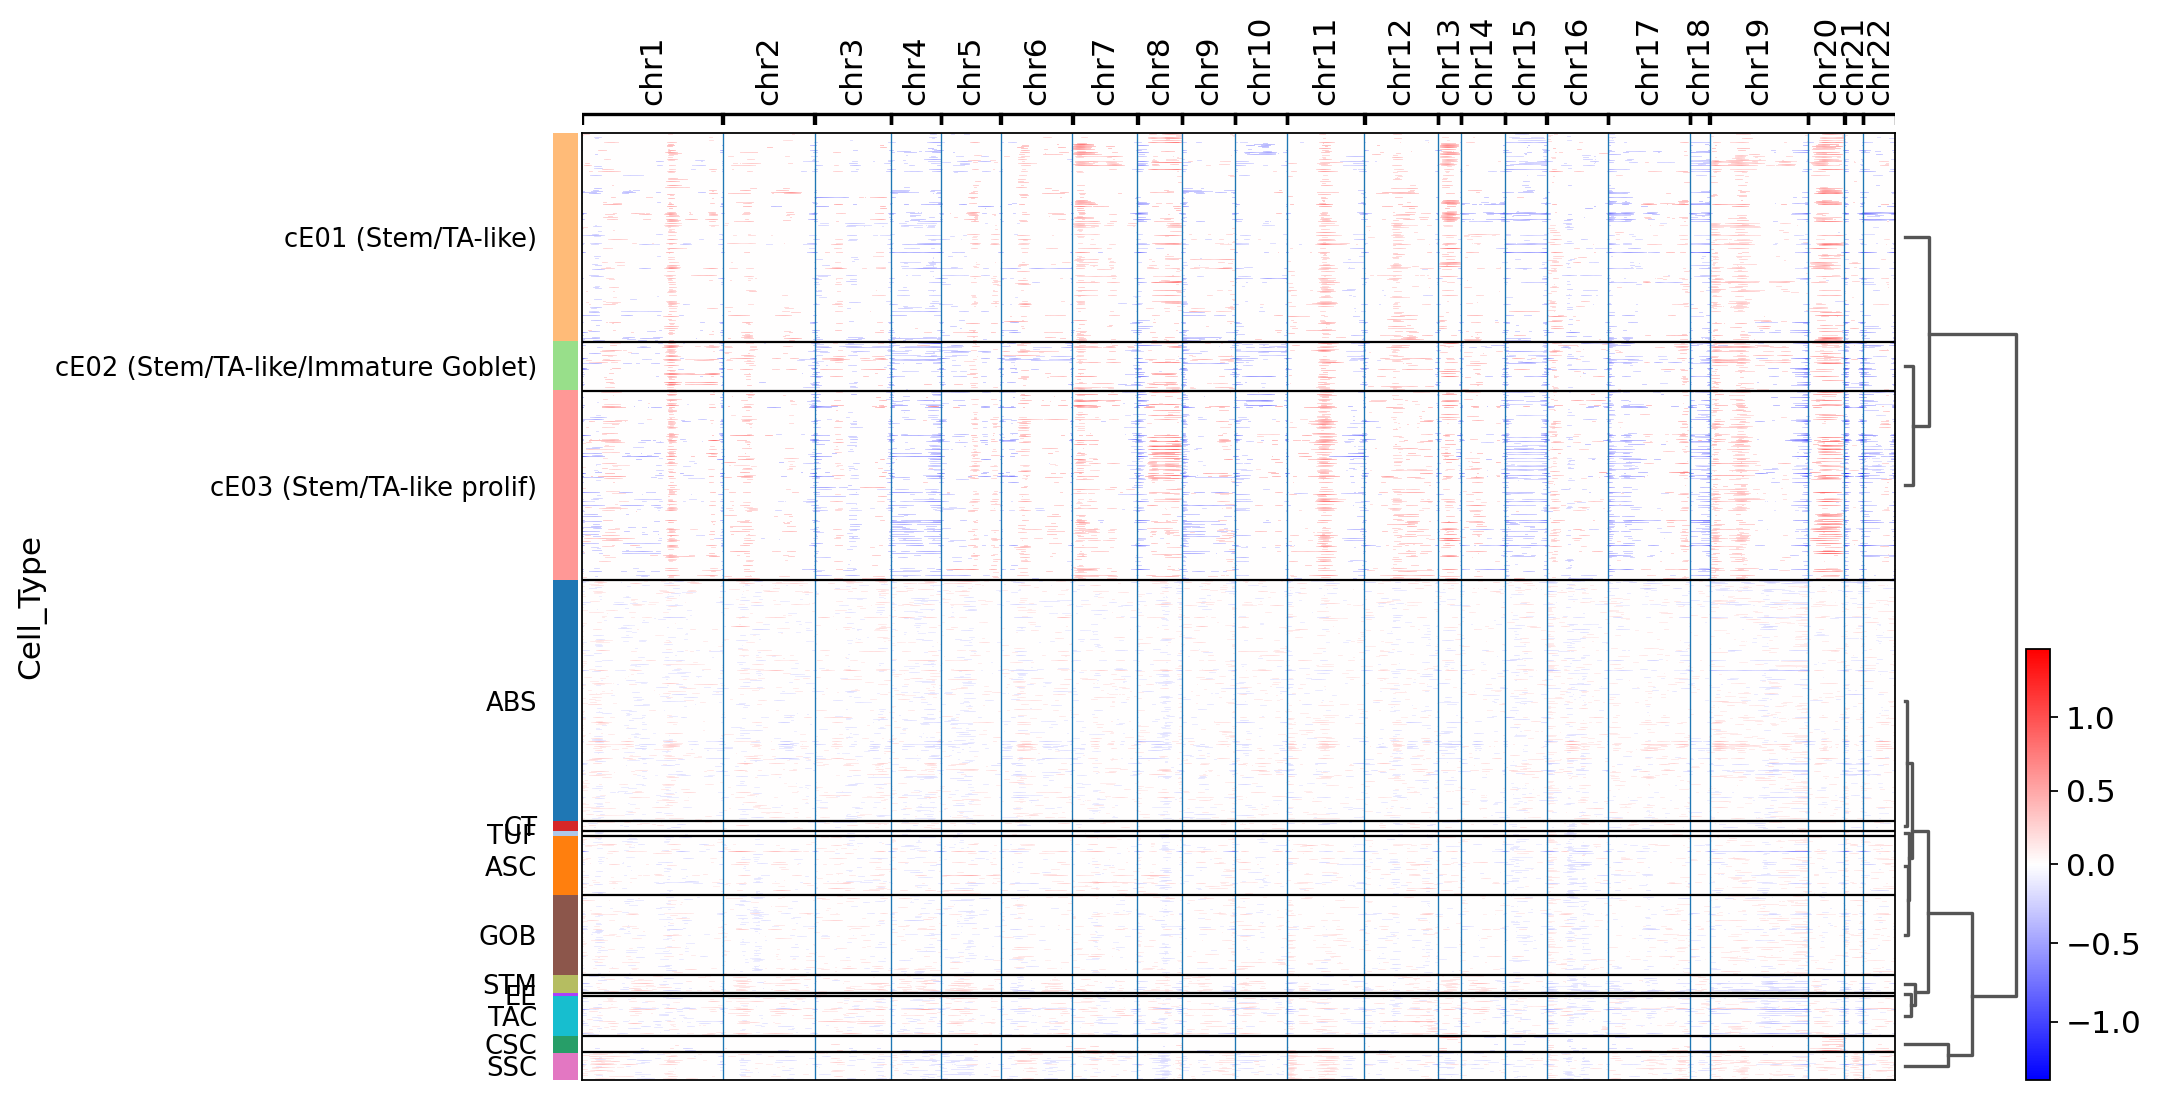

In [36]:
# plot heatmap with cell types
print("Plotting Cell_Type CNV heatmap")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Cell_Type",
    save="_broad_vumc_comb_epi_CellType.png",
    dendrogram=True,
    figsize=(12,8),
)

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical
... storing 'Tumor_Type' as categorical


Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: AD, CRC, NL, etc.
var_group_labels: chr1, chr2, chr3, etc.


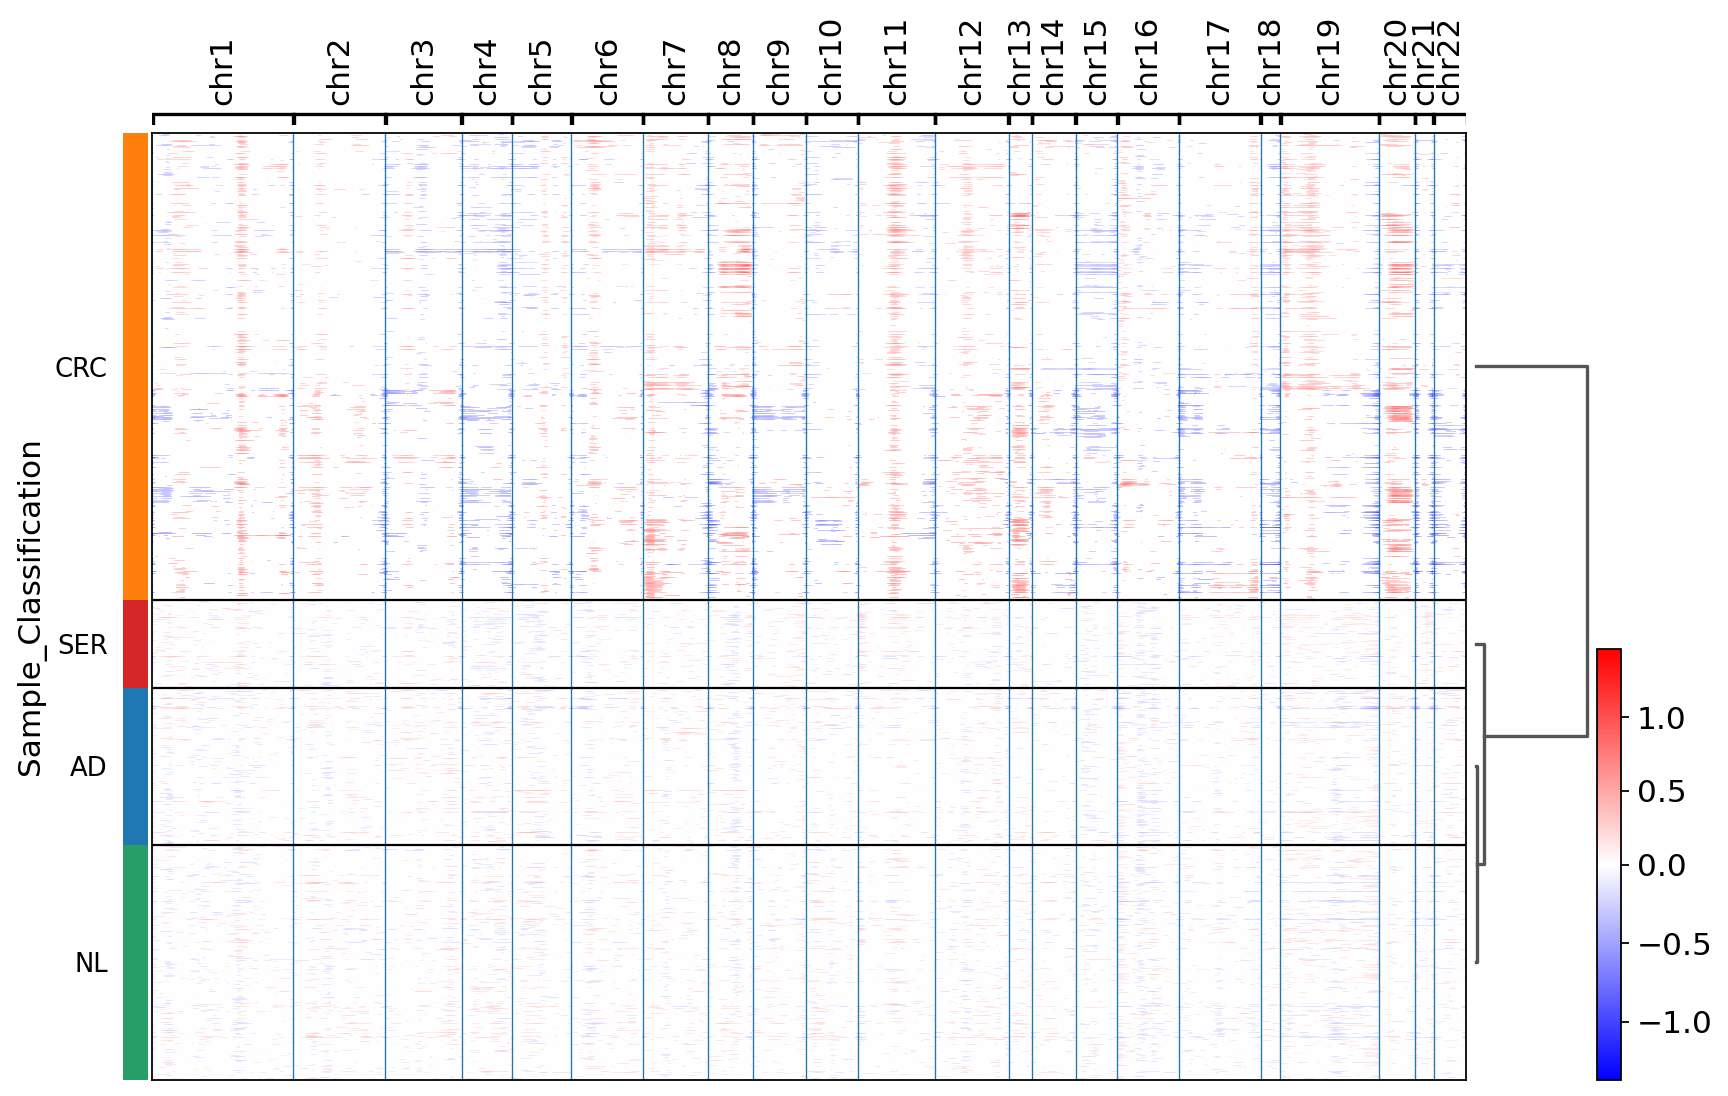

In [37]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Sample_Classification",
    save="_broad_vumc_comb_epi_sampleclass.png",
    dendrogram=True,
    figsize=(12,8),
)

---
Stratify CRC samples by MMR status

In [38]:
a_comb.obs["Tumor_Type2"] = a_comb.obs.Sample_Classification.values
a_comb.obs["Tumor_Type2"] = a_comb.obs["Tumor_Type2"].astype(str)
a_comb.obs.loc[a_comb.obs.Tumor_Type == "MSS", "Tumor_Type2"] = "MSS"
a_comb.obs.loc[a_comb.obs.Tumor_Type == "MSI", "Tumor_Type2"] = "MSI-H"
a_comb.obs.loc[a_comb.obs.MMRStatusTumor == "MSS", "Tumor_Type2"] = "MSS"
a_comb.obs.loc[a_comb.obs.MMRStatusTumor == "MSI", "Tumor_Type2"] = "MSI-H"

In [39]:
a_comb.obs.Tumor_Type2 = a_comb.obs.Tumor_Type2.replace({"SER":"SSL/HP","AD":"TA/TVA"})

In [40]:
a_comb.obs.Tumor_Type2.value_counts()

MSS       38368
NL        31917
MSI-H     25003
TA/TVA    21275
SSL/HP    11896
Name: Tumor_Type2, dtype: int64

In [41]:
a_comb.obs.drop(columns="Tumor_Type", inplace=True)
a_comb.obs.rename(columns={"Tumor_Type2":"Tumor_Type"}, inplace=True)

In [42]:
a_comb.obs.Tumor_Type = a_comb.obs.Tumor_Type.astype("category")

In [43]:
a_comb.obs["Tumor_Type"].value_counts()

MSS       38368
NL        31917
MSI-H     25003
TA/TVA    21275
SSL/HP    11896
Name: Tumor_Type, dtype: int64

---
Compare all tumor-derived cells to all adjacent normal cells

In [46]:
a_comb.obs["Tumor_vs_NL"] = a_comb.obs["Tumor_Type"].astype(str)
a_comb.obs.loc[a_comb.obs["Tumor_Type"].isin(["MSI-H","MSS"]), "Tumor_vs_NL"] = "CRC"
a_comb.obs["Tumor_vs_NL"] = a_comb.obs["Tumor_vs_NL"].astype("category")

In [47]:
a_comb.obs["Tumor_vs_NL"].value_counts()

CRC       63371
NL        31917
TA/TVA    21275
SSL/HP    11896
Name: Tumor_vs_NL, dtype: int64

In [48]:
# custom color dictionary for tumor types and normals
cmap_dict = {
    # Tumor Type
    'SSL/HP':"#c4a4e1",'MSI-H':"#7a4fa3",'MSS':"#ffc101",'TA/TVA':"#fee799",'NL':"#1f77b4",
    "MSI-H (CIN+)":"#7a4fa3", 'MSS (HM)':"#ffc101",
    # Tumor Location
    "Cecum":"#1f4e79","Ascending":"#2e74b7","Hepatic Flexure":"#bdd6ef","Transverse":"#ff717a","Descending":"#fe0001","Sigmoid":"#c00101",
    # this one's global
    "nan":"#ffffff",
    # These are black and white for T and F
    "T":"#000000","F":"#ffffff",
    # evolution
    "N":"tab:blue","B":"tab:green","L":"tab:orange",
    # CNV clone domain
    "T":"#000000","S":"tab:pink","E":"tab:red",
    "CRC":"#ffffff",
}
stage_colordict = dict(zip(["AD","I","II","III/IV"], sns.color_palette("Reds", len(["AD","I","II","III/IV"])).as_hex()))
grade_colordict = dict(zip(["G1","G2","G3"], sns.color_palette("Reds", len(["G1","G2","G3"])).as_hex()))
CIN_colordict = dict(zip(["HM","CIN-","CIN+"], sns.color_palette("Reds", len(["HM","CIN-","CIN+"])).as_hex()))
cmap_dict = {**cmap_dict, **stage_colordict, **grade_colordict, **CIN_colordict}

In [49]:
a_comb.uns["Tumor_Type_colors"] = [cmap_dict[x] for x in a_comb.obs.Tumor_Type.cat.categories]

In [50]:
a_comb.uns["Tumor_vs_NL_colors"] = [cmap_dict[x] for x in a_comb.obs.Tumor_vs_NL.cat.categories]

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical


Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: MSI-H, MSS, NL, etc.
var_group_labels: chr1, chr2, chr3, etc.


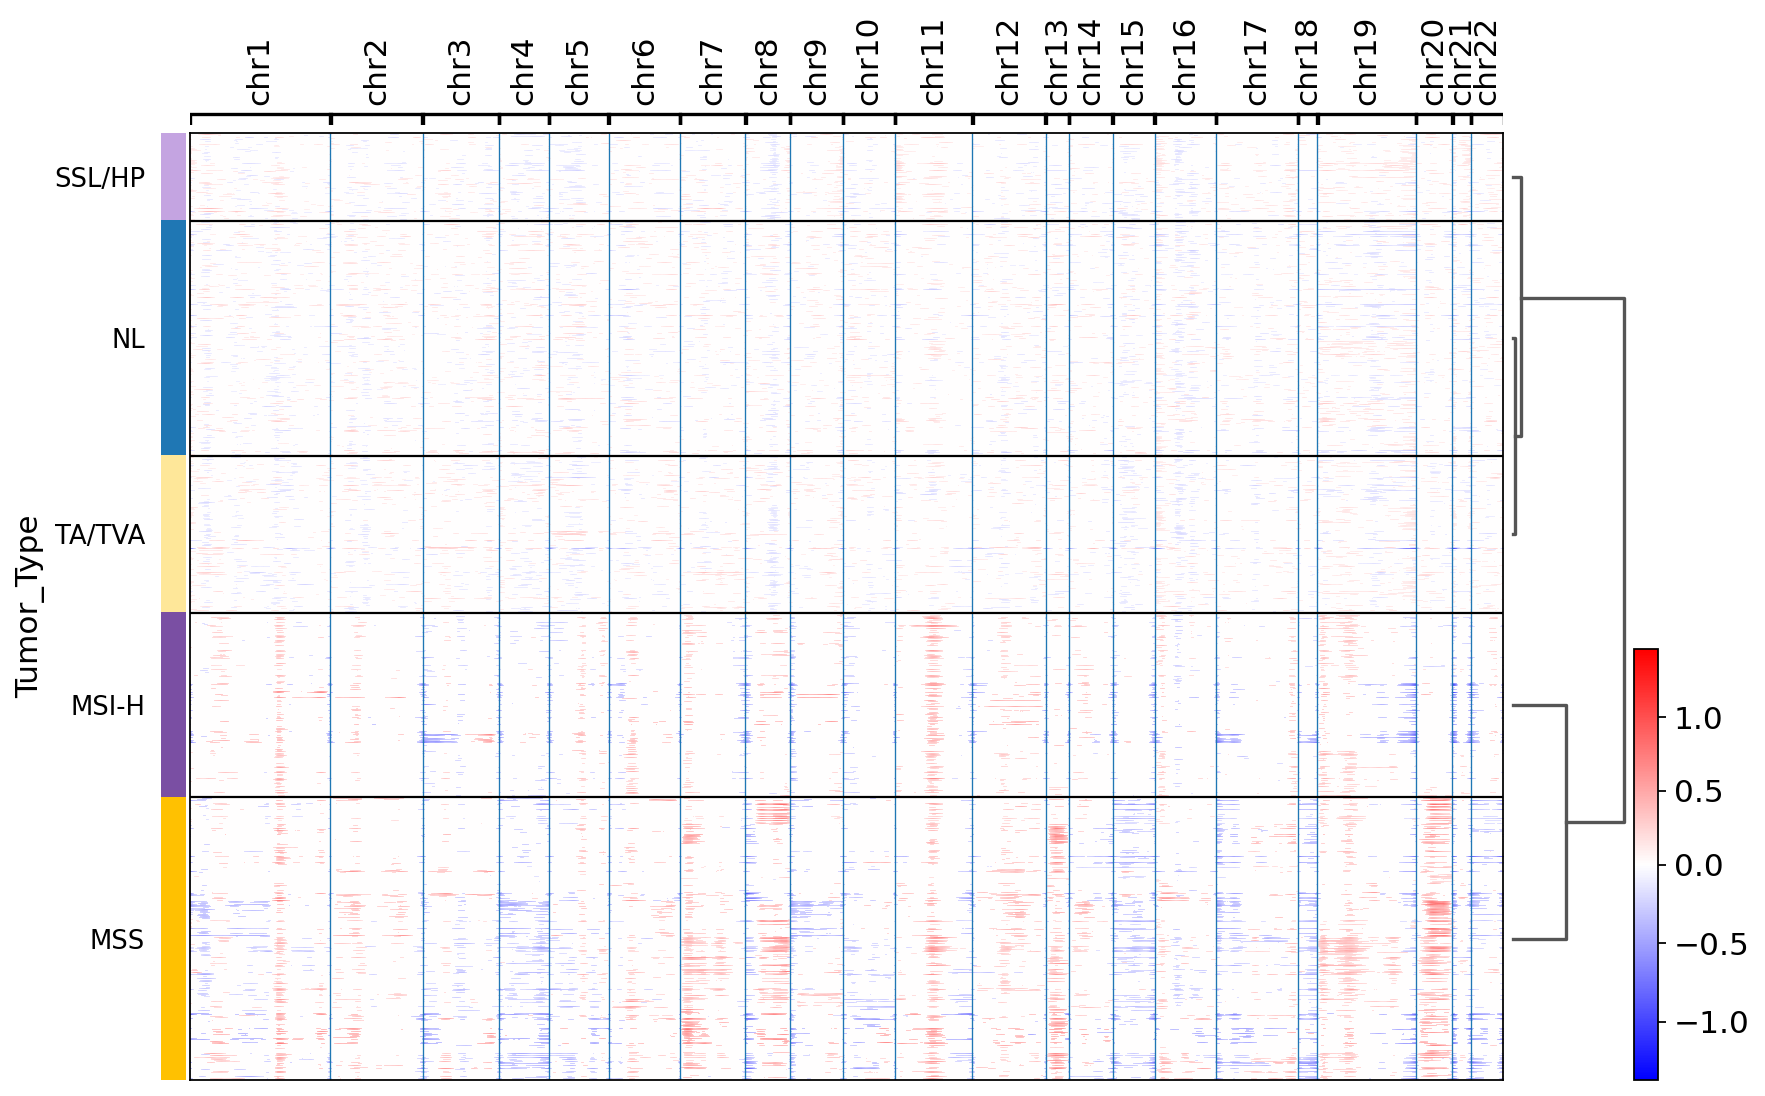

In [51]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Tumor_Type",
    save="_broad_vumc_comb_epi_tumortype.png",
    dendrogram=True,
    figsize=(12,8),
)

... storing 'HTAN Specimen ID' as categorical
... storing 'Cell_Type' as categorical
... storing 'Polyp_Type' as categorical
... storing 'Sample_Classification' as categorical
... storing 'Patient' as categorical


Plotting CNV heatmap with tumor class
         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: CRC, NL, SSL/HP, etc.
var_group_labels: chr1, chr2, chr3, etc.


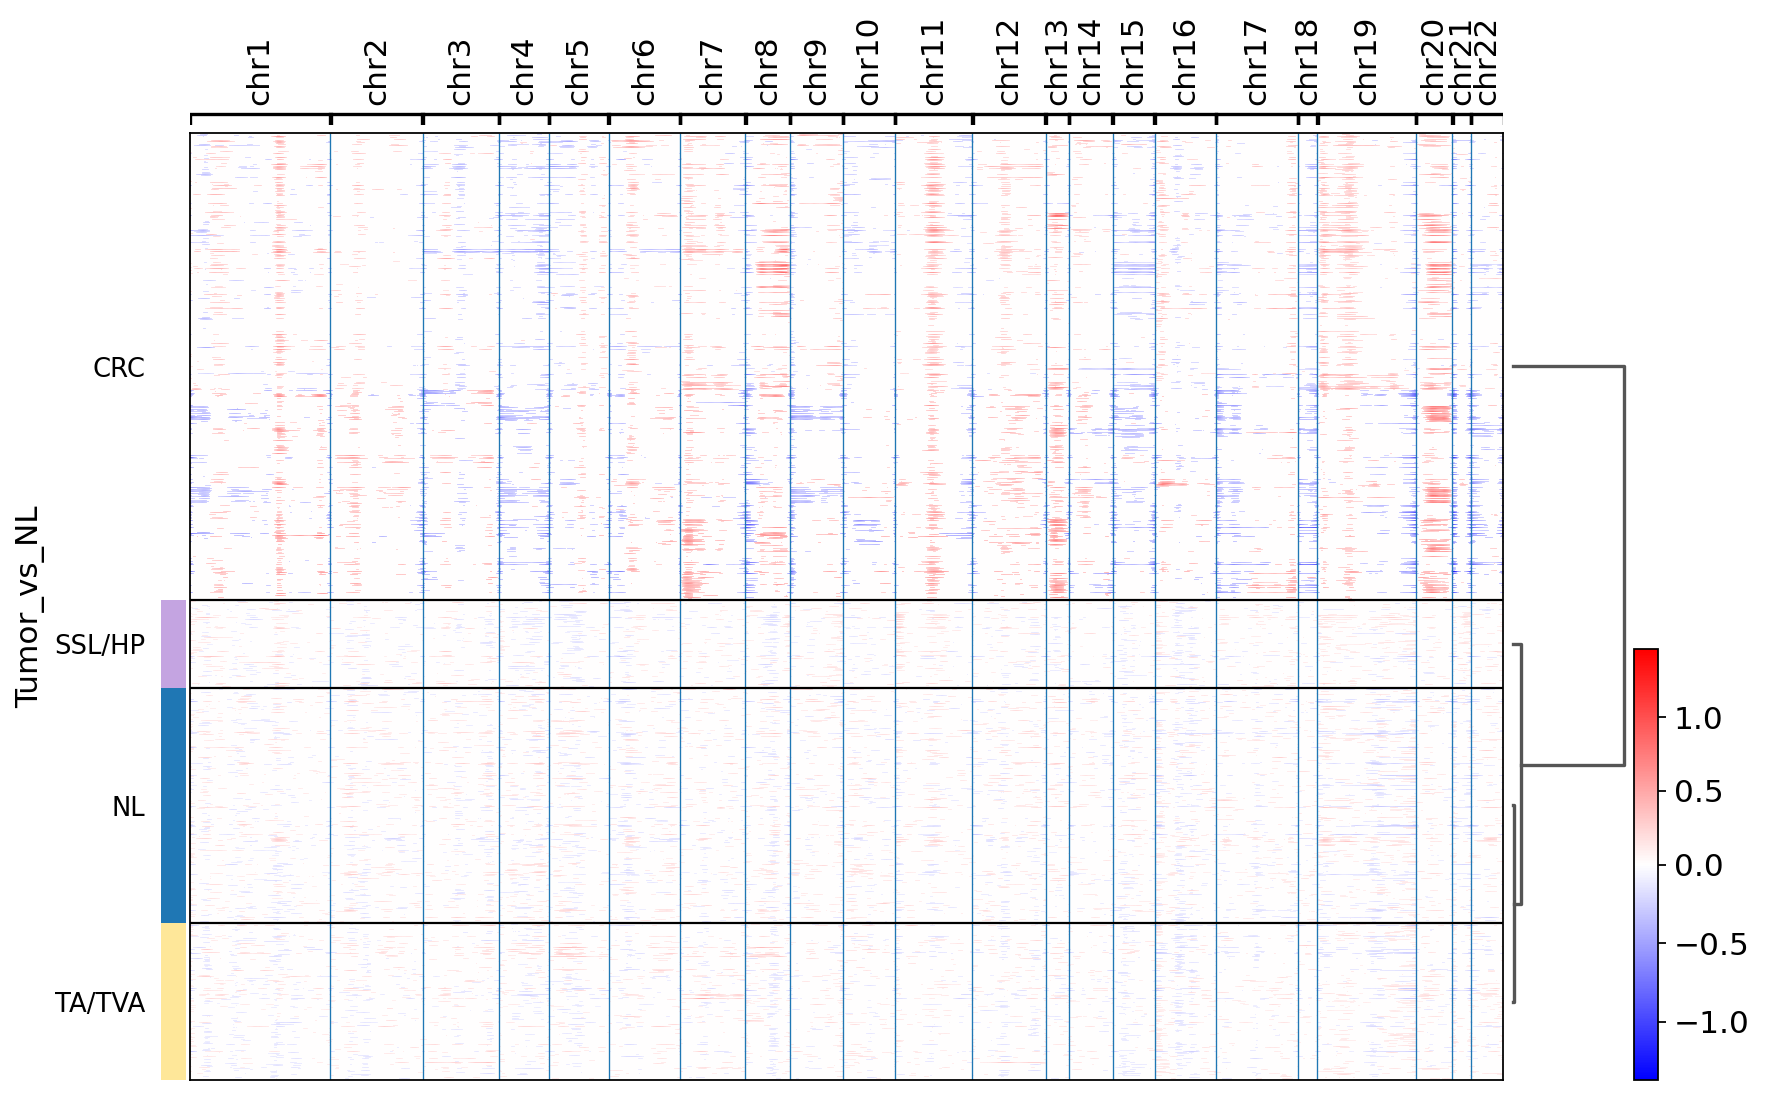

In [52]:
# plot heatmap with tumor type
print("Plotting CNV heatmap with tumor class")
cnv.pl.chromosome_heatmap(
    a_comb,
    groupby="Tumor_vs_NL",
    save="_broad_vumc_comb_epi_tumorvsnl.png",
    dendrogram=True,
    figsize=(12,8),
)

---
## Create boxplots of `CNV Score` by tissue type with B-H corrected t-tests for significance

In [55]:
import sys; sys.path.append("../resources/")
from boxplot_utils import *

Saving ImSig boxplots for Tumor_Type


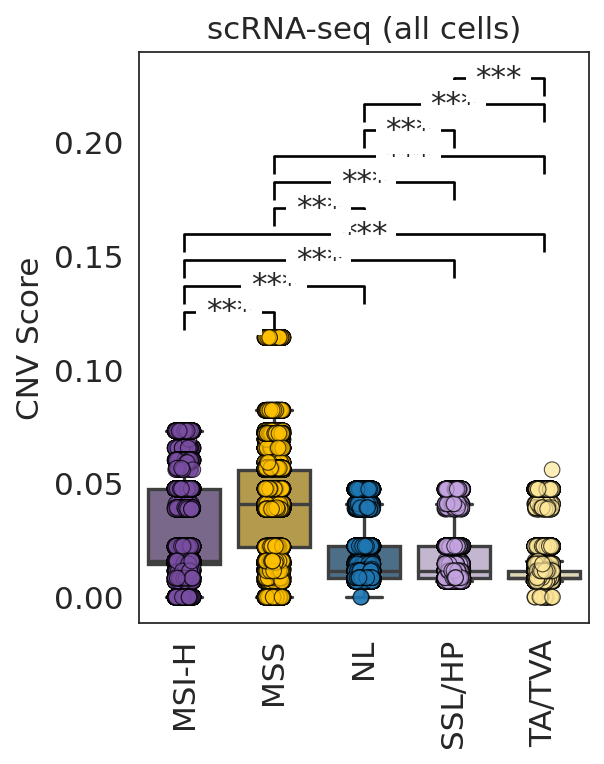

In [56]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_Type"],
    colors=["CNV Score"],
    figsize=(4,5),
    sig=True,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

Saving ImSig boxplots for Tumor_Type


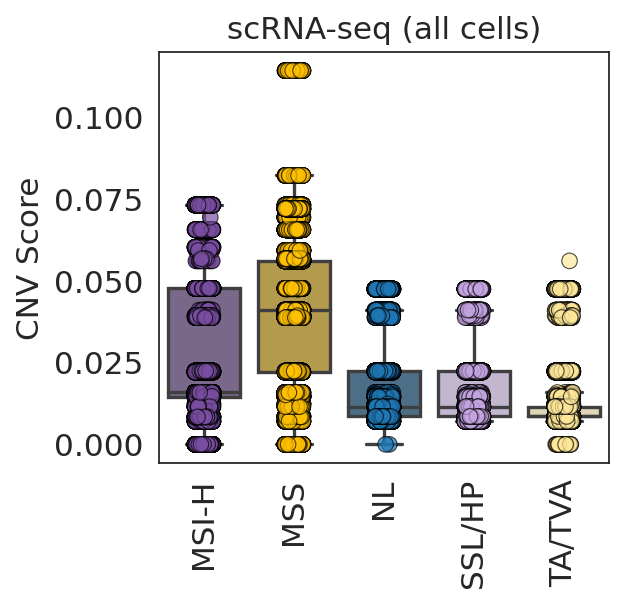

In [57]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_Type"],
    colors=["CNV Score"],
    figsize=(4,4),
    sig=False,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

Saving ImSig boxplots for Tumor_vs_NL


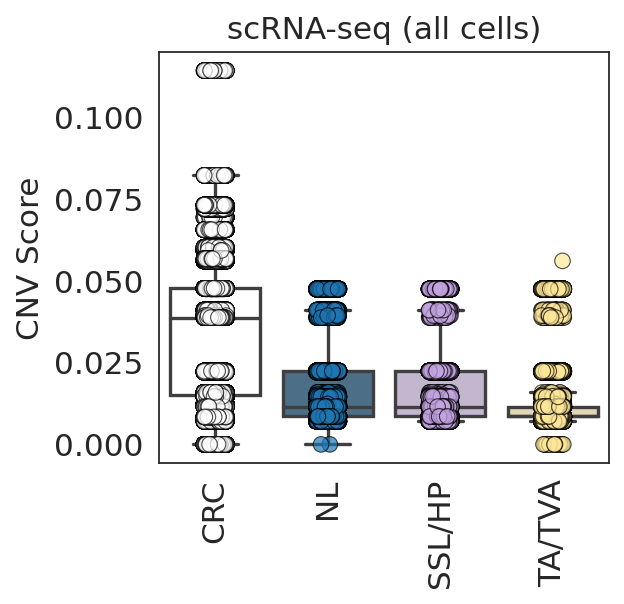

In [58]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_vs_NL"],
    colors=["CNV Score"],
    figsize=(4,4),
    sig=False,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)

Saving ImSig boxplots for Tumor_vs_NL


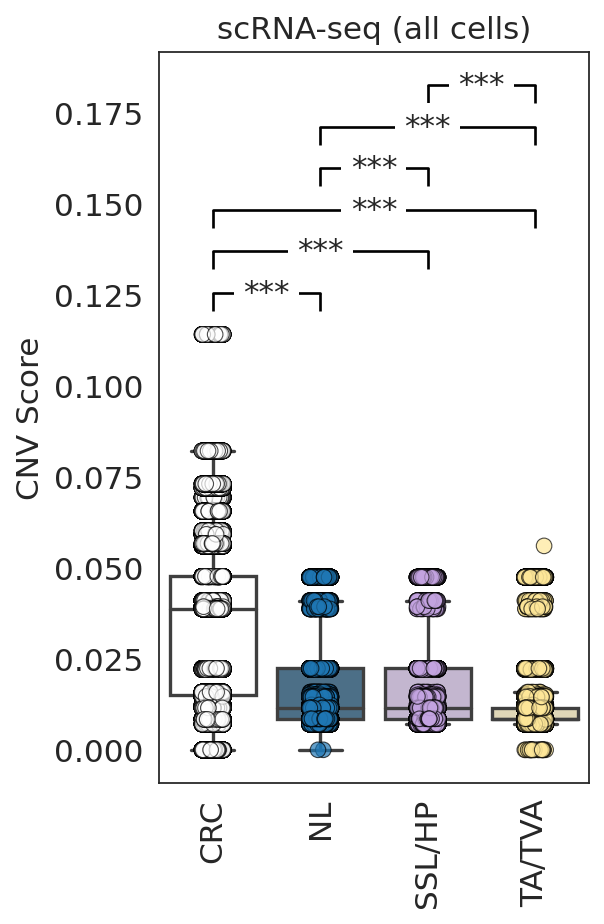

In [59]:
boxplots_group(
    a_comb,
    outdir="scRNA_out/infercnv/",
    obs=["Tumor_vs_NL"],
    colors=["CNV Score"],
    figsize=(4,6),
    sig=True,
    cmap_dict=cmap_dict,
    titles=["scRNA-seq (all cells)"],
)